### Gene expression vs 3D changes during Legionella infection
**cmdoret**


In this report I analyse the relationship between gene expression and spatial changes in _A. castellanii_ upon _L. pneumophila_ infection. I use differential expression results from [Li et al. 2020](https://www.frontiersin.org/articles/10.3389/fcimb.2020.00428/full#h4), lifted over from Neff v1 to our Neff assembly, and look at the concordance between domain borders and gene co-expression.

In [2]:
import os
import re
import itertools as it
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cooler
import pyranges as pr
import scipy.stats as ss
import scipy.cluster.hierarchy as sch
from pandarallel import pandarallel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import umap
from skimage import filters
import statsmodels.api as sm

os.chdir('/home/cmatthey/Repos/Acastellanii_legionella_infection/')

In [3]:
diff_expr = pd.read_csv('data/output/diff_expr/neffv1_liftoff_neff_de_genes.tsv', sep='\t')
liftover = pd.read_csv('data/tmp/liftoff/neffv1_neff_liftover.gff', sep='\t', header=None, usecols=[0, 2, 3, 4, 8])
liftover.columns = ['chrom', 'type', 'start', 'end', 'attr']
liftover = liftover.loc[liftover['type'] == 'gene', :]
liftover['accession'] = liftover['attr'].str.replace(r'ID=gene:([^;]*);.*', r'\1')
liftover['desc'] = liftover['attr'].str.replace(r'.*description=([^;]*);.*', r'\1')

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [4]:
liftover

,chrom,type,start,end,attr,accession,desc
0,scaffold_1,gene,716,1074,ID=gene:ACA1_165080;biotype=protein_coding;des...,ACA1_165080,hypothetical protein
6,scaffold_1,gene,1413,2195,ID=gene:ACA1_294810;biotype=protein_coding;des...,ACA1_294810,hypothetical protein
14,scaffold_1,gene,3175,4403,ID=gene:ACA1_294700;biotype=protein_coding;des...,ACA1_294700,hypothetical protein
22,scaffold_1,gene,6393,7745,ID=gene:ACA1_295040;biotype=protein_coding;des...,ACA1_295040,hypothetical protein
34,scaffold_1,gene,9017,9834,ID=gene:ACA1_352150;biotype=protein_coding;des...,ACA1_352150,hypothetical protein
...,...,...,...,...,...,...,...
224202,scaffold_93,gene,219,937,ID=gene:ACA1_128540;biotype=protein_coding;des...,ACA1_128540,hypothetical protein
224212,scaffold_93,gene,1698,2195,ID=gene:ACA1_128550;biotype=protein_coding;des...,ACA1_128550,hypothetical protein
224218,scaffold_96,gene,347,1621,ID=gene:ACA1_091020;biotype=protein_coding;des...,ACA1_091020,hypothetical protein
224230,scaffold_96,gene,1625,2065,ID=gene:ACA1_091030;biotype=protein_coding;des...,ACA1_091030,hypothetical protein


In [6]:
print(f"{100* diff_expr.c3.isnull().sum() / diff_expr.shape[0]:.2f}% lifted-over genes had no 1:1 match in my de-novo annotation pipeline")

14.13% lifted-over genes had no 1:1 match in my de-novo annotation pipeline


First, let's visualize the differential expression of genes at 8h p.i. using a volcano plot:

<IPython.core.display.Javascript object>


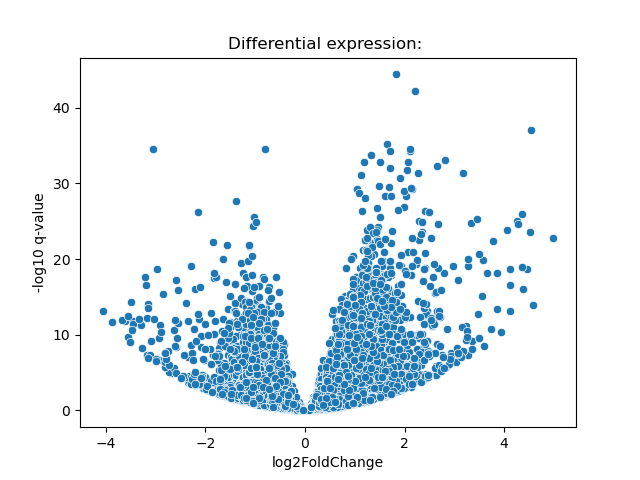

Text(0.5, 1.0, 'Differential expression: ')

In [7]:
%matplotlib notebook

sns.scatterplot(x=diff_expr.log2FoldChange, y=-np.log10(diff_expr.padj))
plt.ylabel("-log10 q-value")
plt.title("Differential expression: ")

Let's subset genes which are highly differentially expressed at 8h p.i. This is the most similar timepoint to the Hi-C dataset (5h p.i.):


In [8]:
PADJ_THRESH = 0.05
L2FC_THRESH = 1

In [9]:
sig_expr = diff_expr.loc[(diff_expr.padj < PADJ_THRESH) & (abs(diff_expr.log2FoldChange) > L2FC_THRESH), :].sort_values('padj')

In [10]:
sig_expr = sig_expr.merge(liftover, on='accession', how='left').sort_values('padj')
sig_expr = sig_expr.dropna()
sig_expr.start = sig_expr.start.astype(int)
sig_expr.end = sig_expr.end.astype(int)
sig_expr = sig_expr.drop_duplicates(subset=['accession']).reset_index(drop=True)

In [11]:
print(
    f'We subsetted {sig_expr.shape[0]} genes ({100*sig_expr.shape[0] / diff_expr.shape[0]:.2f}%) ',
    f'with more than {L2FC_THRESH} log2 fold change and adjusted p-value below {PADJ_THRESH}.')

We subsetted 1894 genes (11.16%)  with more than 1 log2 fold change and adjusted p-value below 0.05.


Li et al reported that sirtuin-related genes were upregulated during infection, notably ACA1_153540. Let's have a look at these.

In [12]:
sig_expr.loc[sig_expr.accession ==  'ACA1_153540', :]


,accession,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,c3,chrom,type,start,end,attr,desc
38,ACA1_153540,1458.066017,4.365291,0.388818,11.227093,3.001928e-29,1.057850e-26,BAESF_07614,scaffold_22,gene,864198,866815,ID=gene:ACA1_153540;biotype=protein_coding;des...,"transcriptional regulator, Sir2 family protein"


It is indeed in our top differentially expressed gene list. 

For the next, preliminary analyses I will work with the subset of genes from scaffold_1 to avoid blowing up memory.

In [17]:
sub_genes = liftover.loc[liftover.chrom=='scaffold_1', :]

In [13]:
hic_samples = pd.read_csv('samples.tsv', sep='\t', comment='#')
clr = cooler.Cooler('data/input/Neff.mcool::/resolutions/2000')

In [14]:
def get_contact_gene_pairs2(clr: cooler.Cooler, genes: pd.DataFrame, intra=False) -> pd.DataFrame:
    """ Compute average contacts between all gene pairs"""
    if intra:
        combs = []
        for chrom in clr.chroms()[:]['name']:
            combs += list(it.combinations(genes.accession[genes.chrom==chrom], 2))
        combs = pd.DataFrame((combs))
    else:
        combs = pd.DataFrame((it.combinations(genes.accession, 2)))
    combs.columns = ['g1', 'g2']
    combs = combs.merge(genes.loc[:, ['chrom', 'start', 'end', 'accession']], right_on='accession', left_on='g1')
    combs = combs.merge(genes.loc[:, ['chrom', 'start', 'end', 'accession']], right_on='accession', left_on='g2')    
    combs = combs.drop(columns=['g1', 'g2'])
    
    def avg_contacts(r):
        mat = clr.matrix(balance=True, sparse=False).fetch(
            f'{r.chrom_x}:{r.start_x}-{r.end_x}',
            f'{r.chrom_y}:{r.start_y}-{r.end_y}'
        )
        return np.nanmean(mat)
    mean_contacts = combs.parallel_apply(avg_contacts, axis=1)
    combs['mean_contacts'] = mean_contacts
    return combs
    

Now I compute average contacts between all pairs of genes.

In [18]:
#p_hic = get_contact_gene_pairs('data/output/cool/sub_uninfected.mcool::/resolutions/2000', sub_genes)

pandarallel.initialize(progress_bar=True)
p_hic = get_contact_gene_pairs2(clr, sub_genes, intra=True)
p_hic = (
    p_hic
    .rename(columns=lambda c: re.sub(r'_x$', '1', c))
    .rename(columns=lambda c: re.sub(r'_y$', '2', c))
)



INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


When visualising the results, it seems that genes differentially expressed at 8h p.i. do not have stronger contacts change during infection than the rest of the genome. The histogram below shows the proportion of contact change during infection (5h pi).

> Note: Only gene pairs where both genes have nonzero contacts in both conditions (uninfected or infected) were shown.

In [19]:
p_hic.head()

,chrom1,start1,end1,accession1,chrom2,start2,end2,accession2,mean_contacts
0,scaffold_1,716,1074,ACA1_165080,scaffold_1,1413,2195,ACA1_294810,0.719119
1,scaffold_1,716,1074,ACA1_165080,scaffold_1,3175,4403,ACA1_294700,NaN
2,scaffold_1,1413,2195,ACA1_294810,scaffold_1,3175,4403,ACA1_294700,NaN
3,scaffold_1,716,1074,ACA1_165080,scaffold_1,6393,7745,ACA1_295040,NaN
4,scaffold_1,1413,2195,ACA1_294810,scaffold_1,6393,7745,ACA1_295040,NaN


In [21]:
import re
p_hic_sym = pd.concat([
    p_hic, (
    p_hic
    .rename(columns=lambda c: re.sub(r'1$', r'3', c))
    .rename(columns=lambda c: re.sub(r'2$', r'1', c))
    .rename(columns=lambda c: re.sub(r'3$', r'2', c))
    .loc[:, p_hic.columns]
    )]
)

When visualizing the pairwise gene-gene contact matrix, we see clusters appearing along the diagonal.
This confirms that genes closer to each other make more contacts with each other (after detrending for diagonal gradient). This suggest they are involved in some sort of contact domains

<IPython.core.display.Javascript object>


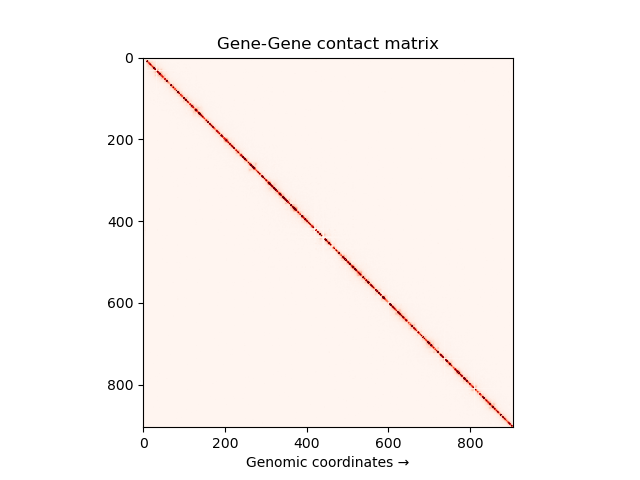

Text(0.5, 0, 'Genomic coordinates →')

In [22]:
%matplotlib notebook
hic_mat = (
    p_hic_sym
    .sort_values(['chrom1', 'start1', 'chrom2', 'start2'])
    .loc[:, ['accession1', 'accession2', 'mean_contacts']]
    .pivot('accession1', 'accession2')
    .fillna(0)
)
hic_mat.columns = [o[1] for o in hic_mat.columns]
ord_genes = [g for g in liftover.sort_values(['chrom', 'start']).accession if g in hic_mat.columns]
hic_mat = hic_mat.loc[ord_genes, :].loc[:, ord_genes]
hic_mat = hic_mat.to_numpy() + hic_mat.to_numpy().T
plt.imshow(np.log1p(hic_mat), vmax = np.percentile(hic_mat, 99.8), cmap='Reds')
plt.title('Gene-Gene contact matrix')
plt.xlabel('Genomic coordinates →')

We can also visualize the detrended contacts vs genomic distance plot, showing a contact enrichment between pairs of genes spaced by ~10kb.

#### Co-variation of gene expression over time

I have formatted the data from Li et al to get the expression of each gene at each timepoint.
First, let's visualize the co-expression of all genes across the 4 time points.


In [24]:
expr_time = pd.read_csv('data/output/diff_expr/li2020_expr_vs_time.tsv', sep='\t')

In [25]:
#expr_time['expr'] = 2**expr_time.log2FoldChange *   expr_time.baseMean
expr_time['expr'] = expr_time['log2FoldChange']

In [26]:
def expr_to_corr(df):
    """Convert time vs expression df to correlation matrix"""
    mat = df.loc[:, ['accession', 'time', 'expr']].pivot('accession', 'time')
    mat.columns = mat.columns.get_level_values(1)
    mat.columns.name = None
    mat = mat.dropna(axis=0)
    corr = mat.transpose().corr().fillna(0)
    
    return corr

corr_mat = expr_to_corr(expr_time)


Here, I cluster all genes along the co-expression matrix using hierarchical clustering. We can see the emergence of two large modules of antagonist genes, and several smaller groups.

In [27]:

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

In [ ]:
%matplotlib notebook

plt.imshow(cluster_corr(corr_mat), cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Co-expression matrix, whole transcriptome")
plt.colorbar()

Here, I use the gene subset defined previously to make analyses faster. 

In [30]:
def corr_to_long(corr):
    """Given a correlation matrix, generate the long format dataframe of the upper triangle."""
    corr.index = corr.index.rename('accession1')
    lcorr = corr.stack().reset_index()
    lcorr = lcorr.rename(columns={'accession': 'accession2', 0: 'coexpr'})
    lower = lcorr.accession1 > lcorr.accession2
    lcorr.accession1[lower], lcorr.accession2[lower] = lcorr.accession2[lower], lcorr.accession1[lower]
    lcorr = lcorr.drop_duplicates(subset=['accession1', 'accession2'])
    
    return lcorr

#corr_sig = expr_to_corr(expr_time.loc[expr_time.accession.isin(sig_expr.accession)])
corr_sub = expr_to_corr(
    expr_time.loc[
        expr_time.accession.isin(sub_genes.accession), :
    ].reset_index(drop=True)
)

long_corr_upper = corr_to_long(corr_sub)


/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


The co-expression matrix now looks much simpler. We still see two main clusters.

<IPython.core.display.Javascript object>


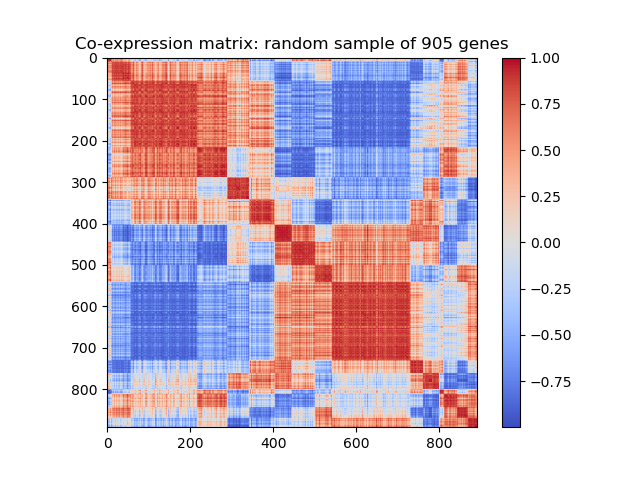

Text(0.5, 1.0, 'Co-expression matrix: random sample of 905 genes')

In [31]:
%matplotlib notebook
plt.imshow(cluster_corr(corr_sub), cmap='coolwarm')
plt.colorbar()
plt.title(f"Co-expression matrix: random sample of {sub_genes.accession.shape[0]} genes")

We previously saw that gene-gene contacts seem to correlate well with genomic position.
Does it hold for co-expression as well ? (Closer genes are regulated together)

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<IPython.core.display.Javascript object>


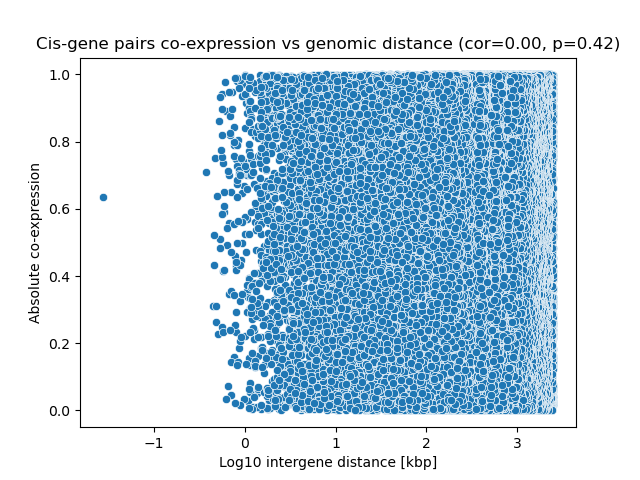

Text(0, 0.5, 'Absolute co-expression')

In [32]:
%matplotlib notebook

cis = long_corr_upper.merge(
    (liftover
         .loc[:, ['accession', 'chrom', 'start']]
         .rename(columns={'accession': 'accession1', 'chrom': 'chrom1', 'start': 'start1'})
    ),
    on='accession1',
    how='left',
).merge(
    (liftover
        .loc[:, ['accession', 'chrom', 'start']]
        .rename(columns={'accession': 'accession2', 'chrom': 'chrom2', 'start': 'start2'})
    ),
    on='accession2',
    how='left',
)
cis = cis.loc[(cis.chrom1 == cis.chrom2), :]
sns.scatterplot(np.log10(abs(cis.start2 - cis.start1)/1000), cis.coexpr.abs())
#sns.kdeplot(np.log10(abs(cis.start2 - cis.start1)/1000), abs(cis.coexpr), color='red', alpha=0.5)
cor = ss.pearsonr(abs(cis.start2 - cis.start1)/1000, abs(cis.coexpr))
plt.title(f'Cis-gene pairs co-expression vs genomic distance (cor={cor[0]:.2f}, p={cor[1]:.2f})')
plt.xlabel("Log10 intergene distance [kbp]")
plt.ylabel("Absolute co-expression")

#### Combining inter-gene contacts and co-expression data
Now let's plug in the Hi-C contact changes with co-expression data ! I still work with the random subset.

In [34]:
# Compute proportion of contact change during infection for each pair of genes
hic_rna = p_hic.merge(long_corr_upper, on=['accession1', 'accession2'], how='inner')

After removing genes with 0 contacts, we see that the distribution of co-expression follows a bimodal distribution, whereas the contacts distribution is ~ gaussian with a long right tail. There does not seem to be a global correlation between contact and co-expression during infection, but we see some "outlier" density spots of highly coexpressed genes with more contacts.

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<IPython.core.display.Javascript object>


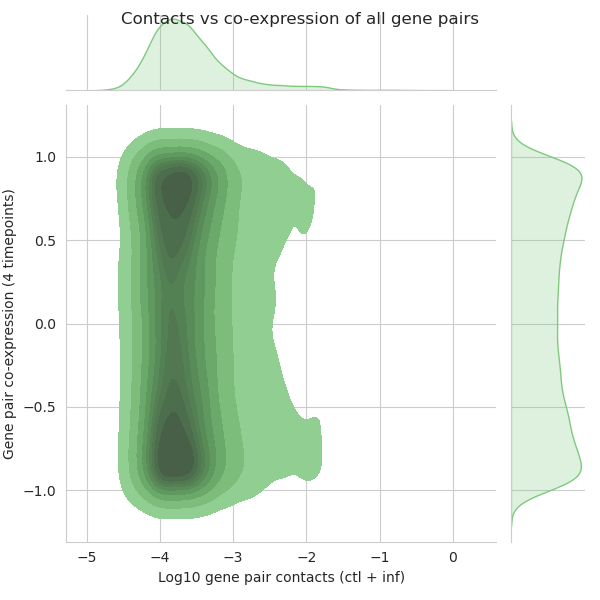

In [35]:
%matplotlib notebook
# Dropping all gene pairs where at least one gene has zero contacts
hr_clean = hic_rna.dropna().loc[hic_rna.mean_contacts > 0, :]
with sns.axes_style("whitegrid"):
    sns.set_palette("Accent")
    jp = sns.jointplot(np.log10(hr_clean.mean_contacts), hr_clean.coexpr, kind='kde', fill=True)
    plt.suptitle('Contacts vs co-expression of all gene pairs')
    jp.ax_joint.set_xlabel('Log10 gene pair contacts')
    jp.ax_joint.set_ylabel('Gene pair co-expression (4 timepoints)')

If we restrict this analysis to intrachromosomal gene pairs, the contact distribution becomes bimodal as well. Hinting there is a subgroup of gene pairs with a higher contact density.

### Impact of domains on coexpression

In mammals, genes within the same TAD are usually co-regulated. Here, I assess whether genes in the same contact domain (predetected using chromosight) are more co-expressed than others.

In [42]:
# Load domains coordinates
domains = pd.read_csv('tmp/domains_neff.tsv', sep='\t')
# Combine (merge) overlapping domains
domains = pr.PyRanges(
    (domains
        .loc[:, ['chrom1', 'start1', 'start2', 'corner_id']]
        .rename(columns={'chrom1': 'Chromosome', 'start1': 'Start', 'start2': 'End'})
    )
)
# Assign a unique ID to every non overlapping domain
domains = domains.sort().insert(pd.Series(domains.df.index.values, name='domain_id'))

In [43]:
domains.df

,Chromosome,Start,End,corner_id,domain_id
0,scaffold_1,44000,100000,1,0
1,scaffold_1,440000,472000,9,1
2,scaffold_1,704000,732000,15,2
3,scaffold_1,704000,748000,15,3
4,scaffold_1,732000,800000,16,4
...,...,...,...,...,...
492,scaffold_33,252000,308000,968,492
493,scaffold_35,8000,40000,970,493
494,scaffold_35,40000,72000,971,494
495,scaffold_36,4000,24000,972,495


In [44]:
# Get overlap between left genes and domains
rna1 = pr.PyRanges((hic_rna
    .loc[:, ['chrom1', 'start1', 'end1', 'accession1', 'accession2']]
    .rename(columns={'chrom1': 'Chromosome', 'start1': 'Start', 'end1': 'End'})))
# Get overlaps between right genes and domains
rna2 = pr.PyRanges((hic_rna
    .loc[:, ['chrom2', 'start2', 'end2', 'accession1', 'accession2']]
    .rename(columns={'chrom2': 'Chromosome', 'start2': 'Start', 'end2': 'End'})))


In [45]:
import re
# Merge left- and right-gene overlaps by pair
domain_pairs = pd.merge(
    rna1.join(domains, how='containment').df,
    rna2.join(domains, how='containment').df,
    on=['accession1', 'accession2'],
    suffixes=['1', '2']
)

# remove extra columns from resulting structure
domain_pairs = domain_pairs.loc[:, ['accession1', 'accession2', 'domain_id1', 'domain_id2']]
# Add domain information to the original structure
domain_pairs = domain_pairs.merge(hic_rna, on=['accession1', 'accession2'])
domain_pairs = domain_pairs.loc[domain_pairs.chrom1 == domain_pairs.chrom2, :]

In [46]:
domain_pairs

,accession1,accession2,domain_id1,domain_id2,chrom1,start1,end1,chrom2,start2,end2,mean_contacts,coexpr
0,ACA1_194830,ACA1_194840,0,0,scaffold_1,47179,47658,scaffold_1,48170,48610,0.098559,0.997108
1,ACA1_194830,ACA1_194850,0,0,scaffold_1,47179,47658,scaffold_1,48674,49495,0.098559,0.186722
2,ACA1_194840,ACA1_194850,0,0,scaffold_1,48170,48610,scaffold_1,48674,49495,0.290218,0.227105
3,ACA1_194830,ACA1_194860,0,0,scaffold_1,47179,47658,scaffold_1,49999,51872,0.072570,0.968495
4,ACA1_194840,ACA1_194860,0,0,scaffold_1,48170,48610,scaffold_1,49999,51872,0.203185,0.984393
...,...,...,...,...,...,...,...,...,...,...,...,...
23832,ACA1_038540,ACA1_272600,24,23,scaffold_1,2383024,2384953,scaffold_1,2435195,2439576,0.001600,0.218001
23833,ACA1_038550,ACA1_272600,23,23,scaffold_1,2390270,2394824,scaffold_1,2435195,2439576,0.002576,-0.044281
23834,ACA1_038550,ACA1_272600,24,23,scaffold_1,2390270,2394824,scaffold_1,2435195,2439576,0.002576,-0.044281
23835,ACA1_038560,ACA1_272600,23,23,scaffold_1,2394853,2396310,scaffold_1,2435195,2439576,0.003936,0.241472


/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(27.0, 0.5, 'Inter-gene distance')

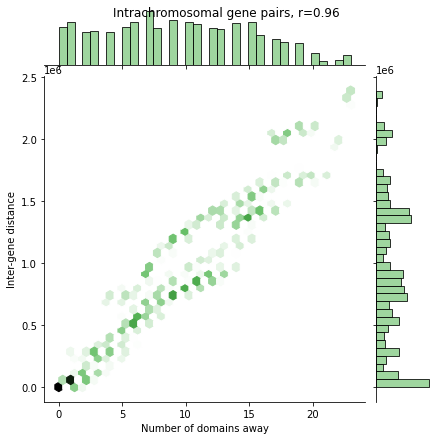

In [47]:
%matplotlib inline
gg_dist = abs(domain_pairs.start2 - domain_pairs.start1)
n_doms = abs(domain_pairs.domain_id2 - domain_pairs.domain_id1)

sns.jointplot(n_doms, gg_dist, kind='hex')

plt.suptitle(
    f'Intrachromosomal gene pairs, r={ss.pearsonr(n_doms, gg_dist)[0]:.2f}'
)
plt.xlabel("Number of domains away")
plt.ylabel("Inter-gene distance")

In [49]:
print(np.mean(abs(domain_pairs.mean_contacts[domain_pairs.domain_id1 != domain_pairs.domain_id2])))
print(np.mean(abs(domain_pairs.mean_contacts[domain_pairs.domain_id1 == domain_pairs.domain_id2])))

0.001020088999663792
0.04066455937158691


Subset gene pairs within distance ~= the size of a domain to compare genes pairs in the same distance range.

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<IPython.core.display.Javascript object>


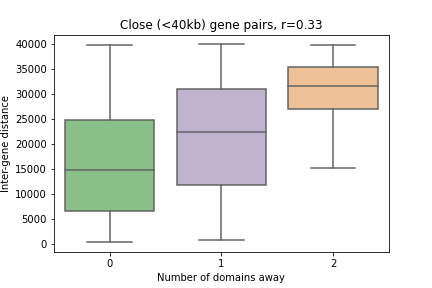

Text(0, 0.5, 'Inter-gene distance')

In [50]:
%matplotlib notebook
domain_size = np.median(domains.df.End - domains.df.Start)
close_pairs = domain_pairs.query(
    '(chrom1 == chrom2) & ((start2 - start1) < @domain_size)'
)
gg_dist = abs(close_pairs.start2 - close_pairs.start1)
n_doms = abs(close_pairs.domain_id2 - close_pairs.domain_id1)
sns.boxplot(n_doms, gg_dist)

plt.title(
    f'Close (<{int(domain_size)//1000}kb) gene pairs, r={ss.pearsonr(n_doms, gg_dist)[0]:.2f}'
)
plt.xlabel("Number of domains away")
plt.ylabel("Inter-gene distance")

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


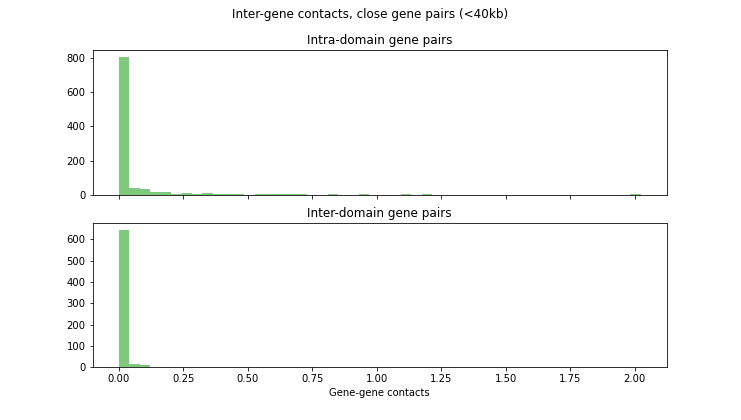

Text(0.5, 0.98, 'Inter-gene contacts, close gene pairs (<40kb)')

In [52]:
%matplotlib notebook

close_pairs['intra_domain'] = [
    'intra' if i else 'inter' for i in close_pairs.domain_id1 == close_pairs.domain_id2]

fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].hist(
    close_pairs.mean_contacts[close_pairs.intra_domain == 'intra'].abs(),
    50
)
ax[0].set_title("Intra-domain gene pairs")
ax[1].hist(
    close_pairs.mean_contacts[close_pairs.intra_domain == 'inter'].abs(),
    50
)
ax[1].set_title("Inter-domain gene pairs")
ax[1].set_xlabel("Gene-gene contacts")
plt.suptitle(f"Inter-gene contacts, close gene pairs (<{int(domain_size//1000)}kb)")

In [53]:
pval = ss.mannwhitneyu(
    close_pairs.mean_contacts[close_pairs.intra_domain=='intra'],
    close_pairs.mean_contacts[close_pairs.intra_domain=='inter']
)[1]
print(
    f'Intra-domain gene pairs have more contacts have more contacts than inter-domain gene pairs: p={pval:.2e}'
)

Intra-domain gene pairs have more contacts have more contacts than inter-domain gene pairs: p=1.37e-38


<IPython.core.display.Javascript object>


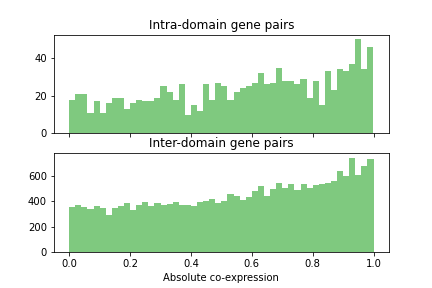

Text(0.5, 1.0, 'Inter-domain gene pairs')

In [54]:
%matplotlib notebook

domain_pairs['intra_domain'] = [
    'intra' if i else 'inter' for i in domain_pairs.domain_id1 == domain_pairs.domain_id2]

fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].hist(
    domain_pairs.coexpr[domain_pairs.intra_domain == 'intra'].abs(),
    50
)
ax[0].set_title("Intra-domain gene pairs")
ax[1].hist(
    domain_pairs.coexpr[domain_pairs.intra_domain == 'inter'].abs(),
    50
)
ax[1].set_xlabel("Absolute co-expression")
ax[1].set_title("Inter-domain gene pairs")

It seems that genes within the same TAD are not more co-expressed than genes between different TADs.

In [55]:
pval = ss.mannwhitneyu(
    close_pairs.coexpr[close_pairs.intra_domain == 'intra'].abs(),
    close_pairs.coexpr[close_pairs.intra_domain == 'inter'].abs()
)[1]
print(f'Genes within the same domain are not more co-expressed than genes between different TADs p={pval:.2f}')

Genes within the same domain are not more co-expressed than genes between different TADs p=0.27


In [56]:
close_pairs

,accession1,accession2,domain_id1,domain_id2,chrom1,start1,end1,chrom2,start2,end2,mean_contacts,coexpr,intra_domain
0,ACA1_194830,ACA1_194840,0,0,scaffold_1,47179,47658,scaffold_1,48170,48610,0.098559,0.997108,intra
1,ACA1_194830,ACA1_194850,0,0,scaffold_1,47179,47658,scaffold_1,48674,49495,0.098559,0.186722,intra
2,ACA1_194840,ACA1_194850,0,0,scaffold_1,48170,48610,scaffold_1,48674,49495,0.290218,0.227105,intra
3,ACA1_194830,ACA1_194860,0,0,scaffold_1,47179,47658,scaffold_1,49999,51872,0.072570,0.968495,intra
4,ACA1_194840,ACA1_194860,0,0,scaffold_1,48170,48610,scaffold_1,49999,51872,0.203185,0.984393,intra
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23601,ACA1_038560,ACA1_272620,23,23,scaffold_1,2394853,2396310,scaffold_1,2432050,2432343,0.003859,-0.321024,intra
23602,ACA1_038570,ACA1_272620,23,23,scaffold_1,2396691,2398832,scaffold_1,2432050,2432343,0.004160,0.640415,intra
23718,ACA1_038560,ACA1_272610,23,23,scaffold_1,2394853,2396310,scaffold_1,2432756,2434500,0.003942,0.948195,intra
23719,ACA1_038570,ACA1_272610,23,23,scaffold_1,2396691,2398832,scaffold_1,2432756,2434500,0.005783,-0.262150,intra


As an attempt to decouple genomic distance from domains, I will use a linear model to extract the specific effect of the domain-distance factor.

In [58]:
close_pairs['dom_dist'] = abs(close_pairs.domain_id2 - close_pairs.domain_id1)
close_pairs['bp_dist'] = abs(close_pairs.start2 - close_pairs.start1)
tbl_pairs = close_pairs.loc[:, ['dom_dist', 'bp_dist', 'coexpr']].dropna()
tbl_pairs.head()

y = tbl_pairs['coexpr'].abs()
X = tbl_pairs.loc[:, ['dom_dist', 'bp_dist']]
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
results.summary()

/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/cmatthey/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 coexpr   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.04825
Date:                Tue, 24 Aug 2021   Prob (F-statistic):              0.953
Time:                        20:29:47   Log-Likelihood:                -1668.2
No. Observations:                1693   AIC:                             3342.
Df Residuals:                    1690   BIC:                             3359.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0208      0.031     -0.676      0.499      -0.081       0.040
dom_dist      -0.0004      0.027     -0.013      0.990      -0.054       0.053
bp_dist     4.308e-07   1.45e-06      0.298      0.766   -2.41e-06    3.27e-06
==============================================================================
Omnibus:                    14704.901   Durbin-Watson:                   1.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.841
Skew:                           0.037   Prob(JB):                     2.14e-32
Kurtosis:                       1.564   Cond. No.                     4.47e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.47e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Given the collinearity between explanatory variables, coefficients may be inaccurate, however it is clear that genomic distance has an impact on absolute coexpression, while domain membership does not.

In [285]:
tbl_pairs

,dom_dist,bp_dist,coexpr
0,0,2458,0.799669
1,0,3439,-0.152684
2,0,981,0.169223
3,0,5583,-0.104080
4,0,3125,-0.620295
...,...,...,...
465588,0,64093,-0.989382
466028,0,73592,-0.919548
466029,0,72624,-0.237168
466030,0,70404,-0.277315
